In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data = pd.read_csv('fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [17]:
data.shape

(35887, 3)

In [18]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [19]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [20]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


D:\Installed\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


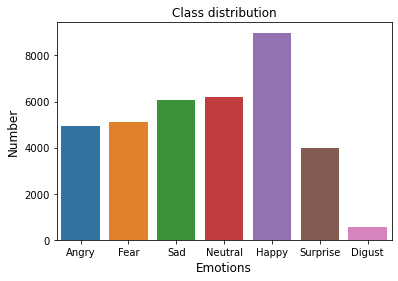

In [21]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

C:\Users\Test\AppData\Local\Temp\ipykernel_27416\2731323236.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


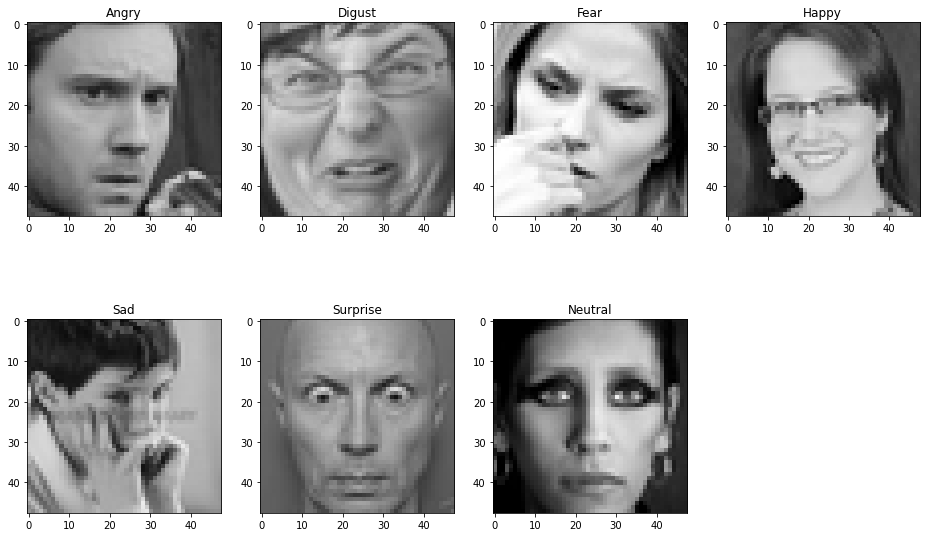

In [22]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

In [23]:
#Pre-processing data
#Summary:
#Splitting dataset into 3 parts: train, validation, test
#Convert strings to lists of integers
#Reshape to 48x48 and normalise grayscale image with 255.0
#Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [24]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


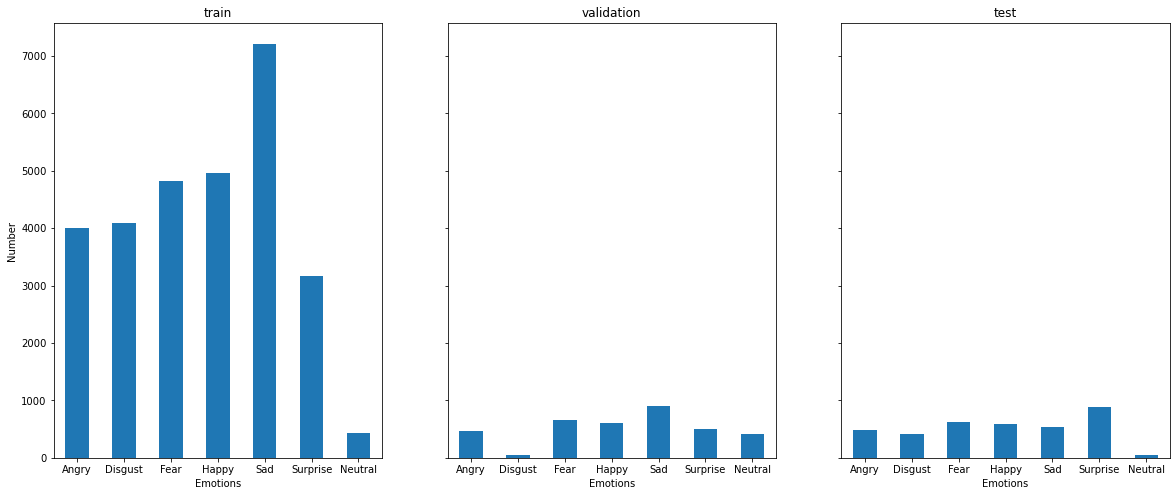

In [25]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [26]:
#Notice that the later two subplots share the same y-axis with the first subplot.

#The size of train, validation, test are 80%, 10% and 10%, respectively.

#The exact number of each class of these datasets are written on top of their x-axis bar.

In [27]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [28]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [29]:
#Building CNN Model
#CNN Architecture:
#Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
#Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
#Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
#Flatten
#Dense -> BN -> Activation
#Dense -> BN -> Activation
#Dense -> BN -> Activation
#Output layer

In [31]:
model = Sequential()

#Layer 1
model.add(Conv2D(num_features, kernel_size=(5, 5), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Layer 2
model.add(Conv2D(2*num_features, kernel_size=(5, 5), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Layer 2
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

#output layer
model.add(Dense(num_classes,activation='sigmoid'))

# Compile model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 44, 44, 64)        1664      
                                                                 
 batch_normalization_4 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 44, 44, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 128)       204928    
                                                                 
 batch_normalization_5 (Batc  (None, 18, 18, 128)     

In [32]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [33]:
# Train model
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

C:\Users\Test\AppData\Local\Temp\ipykernel_27416\4140865401.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),


Epoch 1/50
448/448 - 166s - loss: 0.4147 - accuracy: 0.2821 - val_loss: 0.4133 - val_accuracy: 0.2544 - 166s/epoch - 370ms/step
Epoch 2/50
448/448 - 164s - loss: 0.3445 - accuracy: 0.4019 - val_loss: 0.3661 - val_accuracy: 0.3580 - 164s/epoch - 365ms/step
Epoch 3/50
448/448 - 177s - loss: 0.3175 - accuracy: 0.4616 - val_loss: 0.3309 - val_accuracy: 0.4361 - 177s/epoch - 395ms/step
Epoch 4/50
448/448 - 207s - loss: 0.3044 - accuracy: 0.4889 - val_loss: 0.2993 - val_accuracy: 0.4909 - 207s/epoch - 461ms/step
Epoch 5/50
448/448 - 154s - loss: 0.2953 - accuracy: 0.5074 - val_loss: 0.2842 - val_accuracy: 0.5272 - 154s/epoch - 342ms/step
Epoch 6/50
448/448 - 147s - loss: 0.2865 - accuracy: 0.5270 - val_loss: 0.2830 - val_accuracy: 0.5208 - 147s/epoch - 329ms/step
Epoch 7/50
448/448 - 147s - loss: 0.2822 - accuracy: 0.5363 - val_loss: 0.3054 - val_accuracy: 0.4795 - 147s/epoch - 328ms/step
Epoch 8/50
448/448 - 146s - loss: 0.2781 - accuracy: 0.5433 - val_loss: 0.2864 - val_accuracy: 0.5199 - 

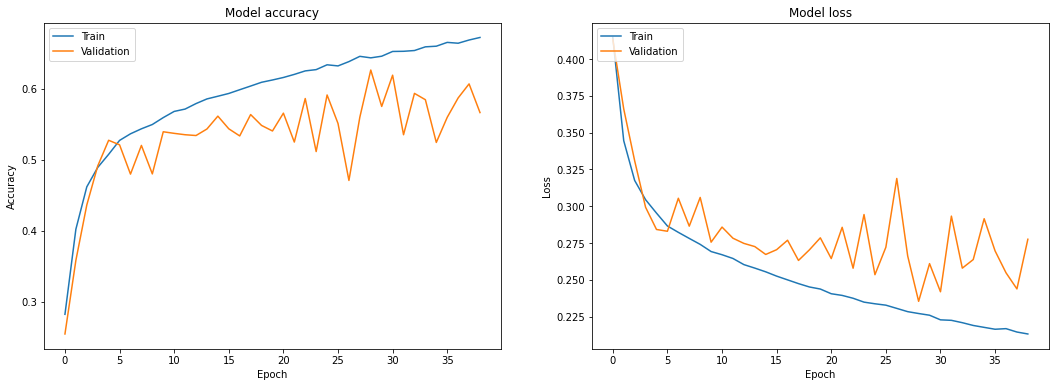

In [36]:
#Visualize Training Performance
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [37]:
#Evaluate Test Performance
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 5s 43ms/step
CNN Model Accuracy on test set: 0.6386
